# Examples on Tensor Networks
For TensorNetwork package see [this link](https://github.com/google/TensorNetwork).

To install required package use 
```bash
pip install tensorflow, tensornetwork
```

First import necessary libraries

In [2]:
import numpy             as np
import tensorflow        as tf
import tensornetwork     as tn
tn.set_default_backend('tensorflow')
import matplotlib.pyplot as plt
import time, logging
logging.getLogger('tensorflow').disabled = True
tf.random.set_seed(66) # execute order 66
from tensornetwork.tn_keras.layers import DenseMPO, DenseDecomp

## TN Layers (retreived from [here](https://github.com/google/TensorNetwork/blob/master/tensornetwork/tn_keras/README.md))

- **DenseMPO**. A TN layer that implements an MPO (Matrix Product Operator), a common tensor network found in condensed matter physics. MPOs are one of the most successful TNs we've seen in practice. Note for this layer the input dimension, output dimension, and number of nodes must all relate in order for the network structure to work. Specifically, ```input_shape[-1]**(1. / num_nodes)``` and ```output_dim**(1. / num_nodes)``` must both be round. The TN looks like:

![Image of MPO](images/mpo.png)

# Example 1:
following ref. [1902.05563](https://arxiv.org/abs/1902.05563).
$$
\frac{d\phi}{dx} + \left(x+\frac{1+3x^2}{1+x+x^3}\right)\phi - x^3 - 2x - x^2\frac{1+3x^2}{1+x+x^3} = 0\quad ,\quad \phi(0)=0
$$
Analytic solution [see this link](https://arxiv.org/pdf/physics/9705023.pdf);
$$
\phi(x) = \frac{e^{-\frac{x^2}{2}}}{1+x+x^3}+x^2
$$

In our setup $\phi(x)$ will be the network.

input setup:

In [12]:
#Generate 100 points in the [0,2] interval
x_train  = np.linspace(0,2,100,endpoint=True)

# Known analytical solutions for comparison
y_train  = np.exp(-0.5*x_train**2)/(1+x_train+x_train**3)+x_train**2

x_t      = x_train.reshape((100,1))

In [13]:
inputs = tf.keras.Input(name='inputs',shape=(1),dtype=tf.dtypes.float32)
hidden = DenseMPO(8,num_nodes=3,bond_dim=5,activation=tf.nn.sigmoid,name='hidden')
output = tf.keras.layers.Dense(1,activation=None,name='output')
model  = tf.keras.Sequential([inputs, hidden,output ])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (DenseMPO)           (None, 8)                 78        
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________


visualise the tensor structure of the network

In [14]:
[x.shape for x in hidden.get_weights()]

[(1, 5, 2), (1, 5, 5, 2), (1, 5, 2), (8,)]

Loss function:

In [15]:
@tf.function
def calc_loss(model,x,optimiser):
    with tf.GradientTape() as tape:
        with tf.GradientTape() as g1:
            g1.watch(x)
            g1.watch(model.trainable_variables)
            y = model(x,training=True)
        dy_dx = g1.gradient(y,x)  
        A = (1+3*x**2)/(1+x+x**3)
        t_loss = (dy_dx + (x + A) * y - x**3 - 2*x - x**2*A)**2
        loss  =  tf.reduce_mean(t_loss+\
                                tf.where(tf.reshape(x==0,(100,1)),(y-1)**2,0))
        tape.watch(loss)

    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimiser.apply_gradients(zip(gradients,model.trainable_variables))
    
    return loss,  y[0]

In [16]:
%%time
epochs = 50000
Adam   = tf.keras.optimizers.Adam(1e-2)

x = tf.constant(x_t,dtype=float)
start_time = time.time()
losses, learning_rate = [], []
for ix in range(1,epochs+1):
    learning_rate.append(Adam.lr.numpy())
    loss, boundary = calc_loss(model,x,Adam)
    losses.append(loss.numpy())
    
    if ix%5000 ==0:
        ls = np.array(losses[-5000:])
        if 100.*ls.std()/ls.min() > 10.:
            tf.keras.backend.set_value(Adam.lr,Adam.lr.numpy()*0.5)

    if ix%10000 == 0 or ix==1:
        elapsed_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
        print('Epoch {:06d}: loss {:.3e}, boundary {:.2f}, Elapsed : {}'.format(ix,loss.numpy(),boundary.numpy()[0],elapsed_time))

Epoch 000001: loss 3.805e+01, boundary 0.71, Elapsed : 00:00:00
Epoch 010000: loss 3.852e-03, boundary 0.99, Elapsed : 00:01:34
Epoch 020000: loss 1.909e-05, boundary 1.00, Elapsed : 00:03:08
Epoch 030000: loss 1.193e-05, boundary 1.00, Elapsed : 00:04:42
Epoch 040000: loss 8.303e-06, boundary 1.00, Elapsed : 00:06:15
Epoch 050000: loss 6.301e-06, boundary 1.00, Elapsed : 00:07:49
CPU times: user 5min, sys: 1min, total: 6min
Wall time: 7min 49s


Plot the loss and learning rate evolution:

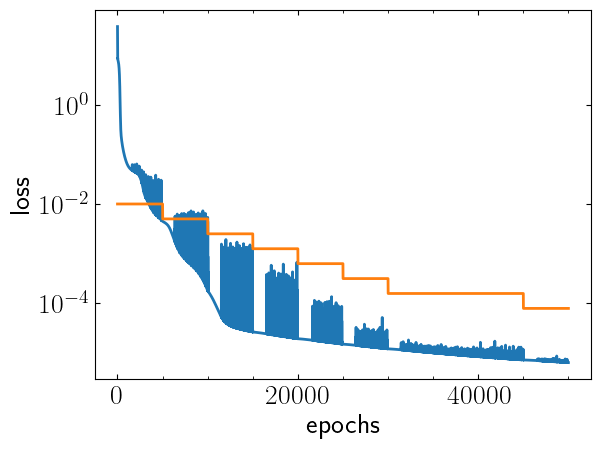

In [17]:
plt.plot(losses)
plt.plot(learning_rate)
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

Compare the network results to the analytic computation:

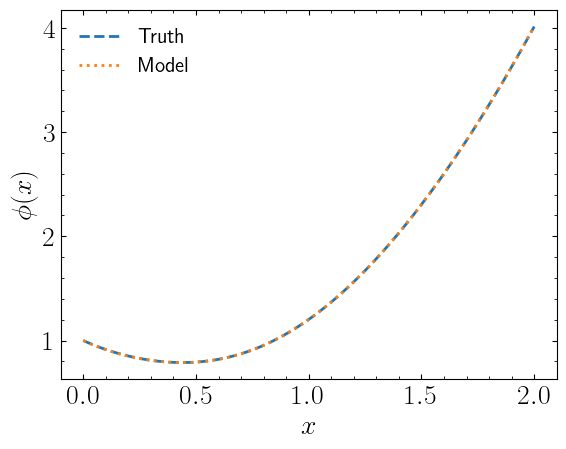

In [18]:
y_pred = tf.reshape(model(x),100).numpy()
plt.plot(x_train,y_train,linestyle='dashed',lw=2)
plt.plot(x_train,y_pred,linestyle='dotted',lw=2)
plt.legend(['Truth','Model'])
plt.ylabel('$\phi(x)$',fontsize=20)
plt.xlabel('$x$',fontsize=20)
plt.show()

# Example 2: Partial Differential Equations

$$
\nabla^2\phi - e^{-x}(x-2+y^3+6y) = 0
$$
boundary conditions;
$$
\phi(0,y) =y^3\quad , \quad \phi(1,y)=(1+y^3)e^{-1}\\
\phi(x,0) = xe^{-x}\quad ,\quad \phi(x,1)=e^{-x}(x+1)
$$
Analytic solution:
$$
\phi(x,y) = e^{-x}(x+y^3)
$$
A different approach with another PDE has been presented in [this link](https://github.com/Rachnog/Neural-Networks-for-Differential-Equations/blob/master/PDE%20example.ipynb)

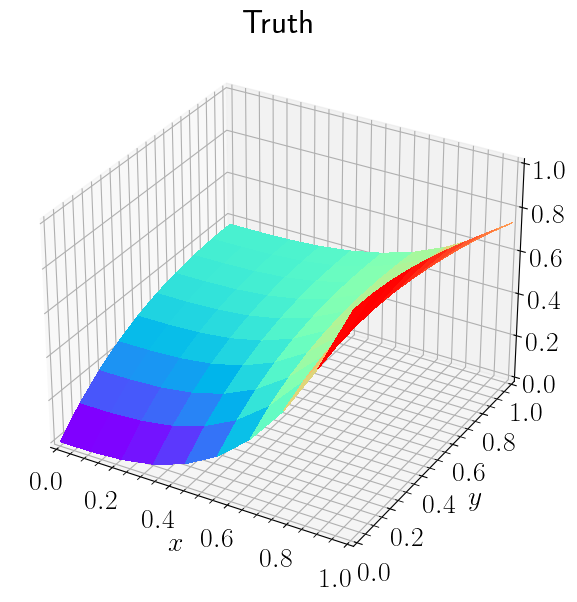

In [19]:
nx = 10
ny = 10

dx = 1. / nx
dy = 1. / ny

x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)

def analytic_solution(x):
    return np.exp(-x[0])*(x[0]+x[1]**3)
surface = np.zeros((ny, nx))

train = []
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface[i][j] = analytic_solution([x, y])
        train.append([x,y])
train = np.array(train)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface, rstride=1, cstride=1, cmap='rainbow',
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.title("Truth")
plt.show()

- **DenseDecomp**. A TN layer comparable to Dense that carries out matrix multiplication with 2 significantly smaller weight matrices instead of 1 large one. This layer is similar to performing a SVD on the weight matrix and dropping the lowest singular values. The TN looks like:

![Image of Decomp](images/decomp.png)

In [22]:
inputs = tf.keras.Input(name='inputs',shape=(2,),dtype=tf.dtypes.float32)
hidden = DenseDecomp(10,decomp_size=5,activation=tf.nn.sigmoid,name='hidden')
output = tf.keras.layers.Dense(1,activation=None,name='output')
model  = tf.keras.Sequential([inputs, hidden, output ])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (DenseDecomp)        (None, 10)                70        
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [25]:
@tf.function
def calc_loss(model,x,optimiser):
    with tf.GradientTape() as tape:
        with tf.GradientTape() as g1:
            with tf.GradientTape() as g2:
                with tf.GradientTape() as g3:
                    tape.watch(x)
                    g1.watch(x)
                    g2.watch(x)
                    g3.watch(x)
                    y = model(x,training=True)
        
                dy_dxi = g3.gradient(y,x)
                dy_dx1 = tf.reshape(dy_dxi[:,0],(100,1))
                dy_dx2 = tf.reshape(dy_dxi[:,1],(100,1))
                g2.watch(dy_dx1)
                g2.watch(dy_dx1)
        
            d2y_dx12 = tf.reshape(g2.gradient(dy_dx1,x)[:,0],(100,1))
        d2y_dx22 = tf.reshape(g1.gradient(dy_dx2,x)[:,1],(100,1))
        Laplacian = tf.add(d2y_dx12,d2y_dx22)
        
        x1 = tf.reshape(x[:,0],(100,1))
        x2 = tf.reshape(x[:,1],(100,1))
        
        f = (Laplacian - tf.exp(-x1)*(x1-2.+x2**3+6.*x2))**2
                
        loss  =  tf.reduce_mean(f +\
                                tf.where(x1==0,  (y-x2**3)**2,                                  0.) +\
                                tf.where(x1==1,  (y-(1.+x2**3)*tf.exp(-1.))**2,                 0.) +\
                                tf.where(x2==0,  (y-x1*tf.exp(-x1))**2,                         0.) +\
                                tf.where(x2==1,  (y-(x1+1.)*tf.exp(-x1))**2,                    0.)
                               ) #reduce_sum and reduce_mean gives same overall result but reduce_mean reaches lower loss values
        tape.watch(loss)

    gradients = tape.gradient(loss, model.trainable_variables)
    # update parameters
    optimiser.apply_gradients(zip(gradients,model.trainable_variables))
    return loss

In [26]:
%%time
epochs = 50000
Adam   = tf.keras.optimizers.Adam(1e-2)

x = tf.constant(train,dtype=float)
start_time = time.time()
losses,learning_rate = [],[]
for ix in range(1,epochs+1):
    learning_rate.append(Adam.lr.numpy())
    loss = calc_loss(model,x,Adam)
    losses.append(loss.numpy())
    if ix%5000 ==0:
        ls = np.array(losses[-5000:])
        if 100.*ls.std()/ls.min() > 10.:
            tf.keras.backend.set_value(Adam.lr,Adam.lr.numpy()*0.5)
    if ix%10000 == 0 or ix==1:
        elapsed_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
        print('Epoch {:05d}: loss {:.3e}, Elapsed : {}'.format(ix,loss.numpy(),elapsed_time))

Epoch 00001: loss 3.383e+00, Elapsed : 00:00:01
Epoch 10000: loss 8.276e-05, Elapsed : 00:01:27
Epoch 20000: loss 4.799e-05, Elapsed : 00:02:52
Epoch 30000: loss 2.992e-05, Elapsed : 00:04:17
Epoch 40000: loss 2.300e-05, Elapsed : 00:05:44
Epoch 50000: loss 1.814e-05, Elapsed : 00:07:10
CPU times: user 6min 44s, sys: 1min, total: 7min 44s
Wall time: 7min 10s


Plot losses and learning rate evolution

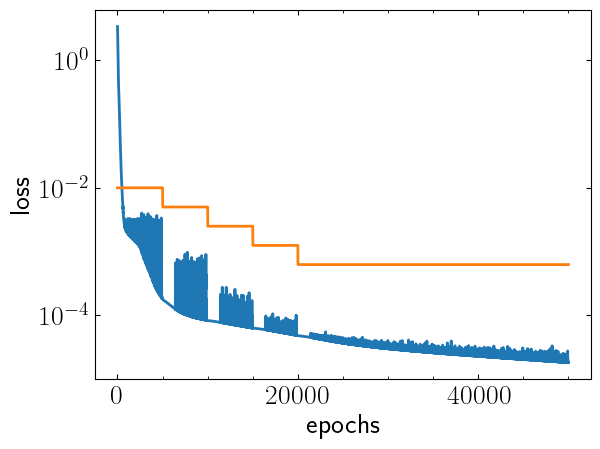

In [27]:
plt.plot(losses)
plt.plot(learning_rate)
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

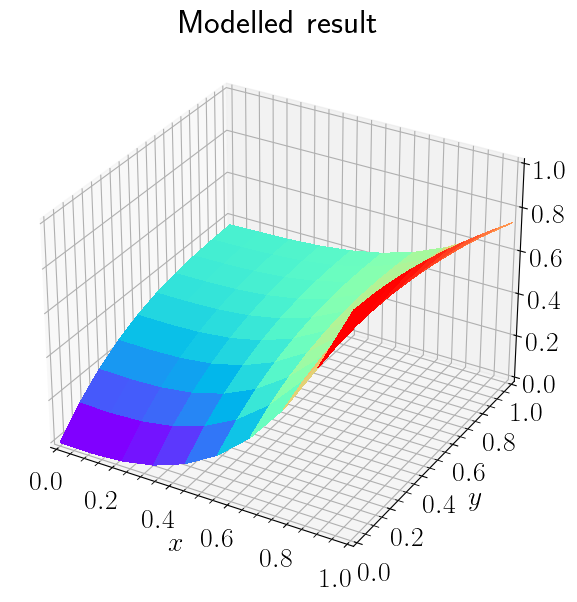

In [28]:
logging.getLogger('tensorflow').disabled = True
surface = np.zeros((x_space.shape[0], y_space.shape[0]))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        inpt = tf.constant([[x,y]],dtype=float)
        surface[i][j] = model(inpt).numpy()[0][0]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface, rstride=1, cstride=1, cmap='rainbow',shade=True,
                        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.title("Modelled result")
plt.show()

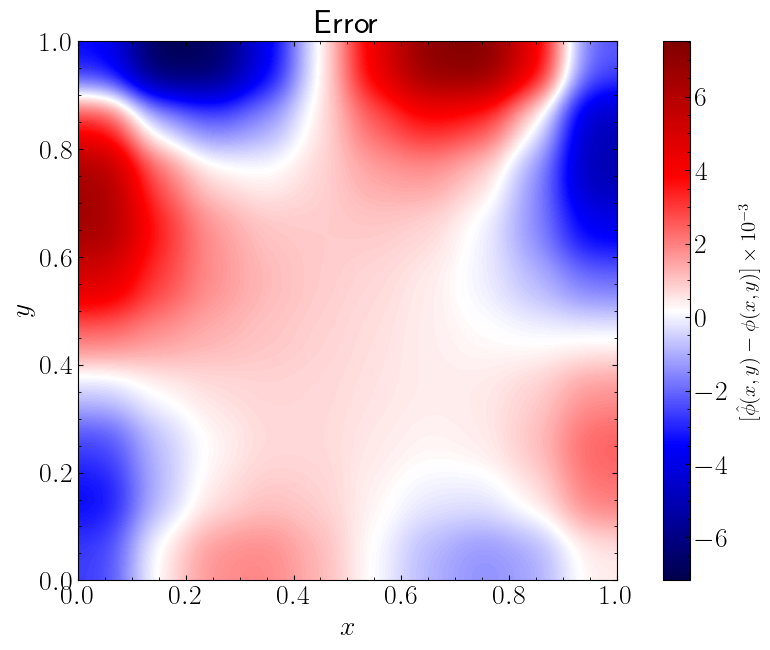

In [29]:
surface_true = np.zeros((x_space.shape[0], y_space.shape[0]))
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface_true[i][j] = analytic_solution([x, y])

fig = plt.figure(figsize=(12,7))
a = plt.imshow((surface - surface_true)*1e3,interpolation='gaussian',norm=plt.Normalize(),extent=[0,1,0,1])
plt.set_cmap('seismic')
cbar = plt.colorbar(a)
cbar.set_label('$[\hat{\phi}(x,y)-\phi(x,y)]\\times10^{-3}$',fontsize=15)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Error")
plt.show()

# Example 3: A neural network comparisson

retreived from [this link](https://github.com/google/TensorNetwork/blob/master/colabs/Tensor_Networks_in_Neural_Networks.ipynb)

Define a TN operator: Here, we simply use a 2 node Matrix Product Operator network to replace the normal dense weight matrix.

In [3]:
class TNLayer(tf.keras.layers.Layer):

    def __init__(self):
        super(TNLayer, self).__init__()
        # Create the variables for the layer.
        self.a_var = tf.Variable(tf.random.normal(shape=(32, 32, 2),
                                                  stddev=1.0/32.0),
                                 name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(32, 32, 2),
                                                  stddev=1.0/32.0),
                                 name="b", trainable=True)
        self.bias = tf.Variable(tf.zeros(shape=(32, 32)),
                                name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using
        # tf.vectorized_map (see below).
        def f(input_vec, a_var, b_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (32, 32))

            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            x_node = tn.Node(input_vec)
            a[1] ^ x_node[0]
            b[1] ^ x_node[1]
            a[2] ^ b[2]

            # The TN should now look like this
            #   |     |
            #   a --- b
            #    \   /
            #      x

            # Now we begin the contraction.
            c = a @ x_node
            result = (c @ b).tensor

            # To make the code shorter, we also could've used Ncon.
            # The above few lines of code is the same as this:
            # result = tn.ncon([x, a_var, b_var], [[1, 2], [-1, 1, 3], [-2, 2, 3]])

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map
        # function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(
            lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, 1024)))

Create a regular FC Network

In [4]:
Dense = tf.keras.layers.Dense
fc_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     Dense(1024, activation=tf.nn.relu),
     Dense(1, activation=None)])
fc_model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              3072      
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,053,697
Trainable params: 1,053,697
Non-trainable params: 0
_________________________________________________________________


Create a network from TN

In [5]:
tn_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     # Here, we replace the dense layer with our MPS.
     TNLayer(),
     Dense(1, activation=None)])
tn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              3072      
                                                                 
 tn_layer (TNLayer)          (None, 1024)              5120      
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________


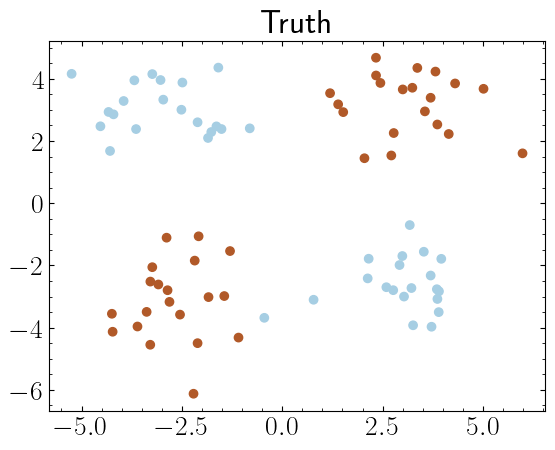

In [6]:
X = np.concatenate([np.random.randn(20, 2) + np.array([3, 3]),
                    np.random.randn(20, 2) + np.array([-3, -3]),
                    np.random.randn(20, 2) + np.array([-3, 3]),
                    np.random.randn(20, 2) + np.array([3, -3])])

Y = np.concatenate([np.ones((40)), -np.ones((40))])

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.title("Truth")
plt.show()

In [7]:
tn_model.compile(optimizer="adam", loss="mean_squared_error")
tn_model.fit(X, Y, epochs=300, verbose=1)

Epoch 1/300


2023-06-21 10:32:02.416180: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/jackaraz/packages/miniconda3/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/tn_layer/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/tn_layer/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/tn_layer/loop_body/GatherV2/pfor/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


3/3 [==============================] - 1s 38ms/step - loss: 0.9825
Epoch 2/300
3/3 [==============================] - 0s 11ms/step - loss: 0.9286
Epoch 3/300
3/3 [==============================] - 0s 10ms/step - loss: 0.8817
Epoch 4/300
3/3 [==============================] - 0s 8ms/step - loss: 0.8303
Epoch 5/300
3/3 [==============================] - 0s 10ms/step - loss: 0.7699
Epoch 6/300
3/3 [==============================] - 0s 11ms/step - loss: 0.6980
Epoch 7/300
3/3 [==============================] - 0s 10ms/step - loss: 0.6124
Epoch 8/300
3/3 [==============================] - 0s 10ms/step - loss: 0.5132
Epoch 9/300
3/3 [==============================] - 0s 10ms/step - loss: 0.4029
Epoch 10/300
3/3 [==============================] - 0s 9ms/step - loss: 0.2930
Epoch 11/300
3/3 [==============================] - 0s 10ms/step - loss: 0.1950
Epoch 12/300
3/3 [==============================] - 0s 9ms/step - loss: 0.1221
Epoch 13/300
3/3 [==============================] - 0s 10ms/step

15/15 [==============================] - 0s 10ms/step


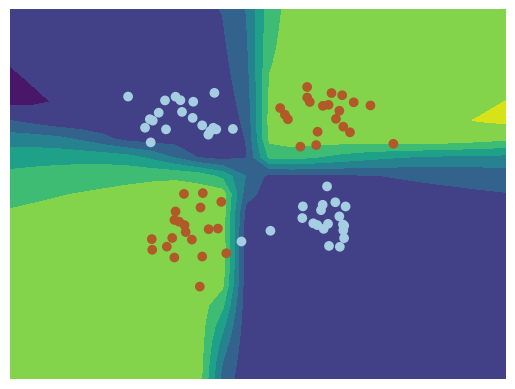

In [8]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = tn_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

## Fully connected network

15/15 [==============================] - 0s 6ms/step


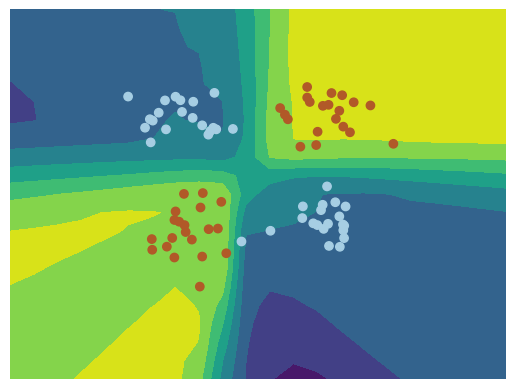

In [9]:

fc_model.compile(optimizer="adam", loss="mean_squared_error")
fc_model.fit(X, Y, epochs=300, verbose=0)
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = fc_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)